In [64]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import math
import torch.nn.functional as F

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(34)

In [65]:
# Regression data function
f = lambda x, epsilon: x + 0.3 * np.sin(2*np.pi * (x+epsilon)) + 0.3 * np.sin(4 * np.pi * (x+epsilon)) + epsilon

def generate_data(N, lower, upper, std, f=f):
    # create data
    x = np.linspace(lower, upper, N)

    y = []
    for i in range(N):
        epsilon = np.random.normal(0, std)
        y.append(f(x[i], epsilon))
    return x, y

# Generate train data
N_train = 2000
x, y = generate_data(N_train, lower=-0.25, upper=1, std=0.02)

# Generate validation data
N_val = 500
x_val, y_val = generate_data(N_val, lower=-0.25, upper=1, std=0.02)

# Generate test data
N_test = 500
x_test, y_test = generate_data(N_test, lower=-0.5, upper=1.5, std=0.02)

line = f(x_test, 0)

In [66]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

def collate_fn(batch):

    x, y = zip(*batch)

    return torch.tensor(x)[:,None], torch.tensor(y)

In [67]:
class Gaussian():
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0, 1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

    @property # @property so we can call self.sigma directly rather than self.sigma()
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):  
        # sample noise from normal distribution 

        epsilon = self.normal.sample(self.rho.size()) 
        epsilon = epsilon.to(self.device)
  
        return self.mu + self.sigma * epsilon # scale with mu and sigma
    
    def log_prob(self, w):
        # log pdf for Gaussian distribution
        return torch.sum(-torch.log(self.sigma) - 0.5*np.log(2*np.pi) - 0.5 * ((w - self.mu) / self.sigma)**2)

In [68]:
class ScaleMixturePrior():
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()

        """
        Implementing the scale mixture prior in equation 7 of the paper.
        From the paper: sigma1 > sigma2 and sigma2 << 1.
        """
        assert sigma1 > sigma2, "Error: sigma1 must be greater than sigma2."
        assert sigma2 < 1, "Error: sigma2 must be less than 1."

        self.pi = pi
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.sigma1 = sigma1
        self.sigma2 = sigma2

        self.gaussian1 = torch.distributions.Normal(torch.tensor(0).to(self.device), sigma1.to(self.device))
        self.gaussian2 = torch.distributions.Normal(torch.tensor(0).to(self.device), sigma2.to(self.device))
       

    def log_prob(self, w):
        """
        Implementing the log pdf for the scale mixture prior
        """

        # log_p1 = self.gaussian1.log_prob(w)
        # log_p2 = self.gaussian2.log_prob(w)

        # return (np.log(self.pi) + log_p1 + np.log(1 - self.pi) + log_p2).sum()

        p1 = torch.exp(self.gaussian1.log_prob(w)) # torch.exp of log pdf so we get the pdf
        p2 = torch.exp(self.gaussian2.log_prob(w))
        return torch.log(self.pi * p1 + (1-self.pi) * p2).sum()

    

In [69]:
# seed workers for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# g = torch.Generator()
# g.manual_seed(0)

traindata = ToyDataset(x, y)
trainloader = DataLoader(traindata, batch_size=500, shuffle=True, collate_fn=collate_fn)

valdata = ToyDataset(x_val, y_val)
valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=collate_fn)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=collate_fn)

NUM_BATCHES = len(trainloader)

In [74]:
class BayesianLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, pi=0.5, sigma1=torch.exp(torch.tensor([-0])), sigma2=torch.exp(torch.tensor([-6]))):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # initialise mu and rho parameters so they get updated in backpropagation
        self.weight_mus = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-2, -1)) 
        self.bias_mus = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(output_dim).uniform_(-2, -1))

        # create approximate posterior distribution
        self.weight_posterior = Gaussian(self.weight_mus, self.weight_rhos)
        self.bias_posterior = Gaussian(self.bias_mus, self.bias_rhos)

        # scale mixture posterior
        self.weight_prior = ScaleMixturePrior(pi=pi, sigma1=sigma1, sigma2=sigma2)
        self.bias_prior = ScaleMixturePrior(pi=pi, sigma1=sigma1, sigma2=sigma2)
        # self.weight_prior = Gaussian(0, sigma1.to(self.device))
        # self.bias_prior = Gaussian(0, sigma1.to(self.device))

        self.log_prior = 0.0
        self.log_variational_posterior = 0.0

        

    def forward(self, x, inference=False):
        if inference:
            # during inference, we simply use the mus of the weights and biases
            w = self.weight_mus
            b = self.bias_mus

            self.log_prior = 0.0
            self.log_variational_posterior = 0.0
        else:
            # sample from approximate posterior distribution
            w = self.weight_posterior.sample()
            b = self.bias_posterior.sample()

            # compute log prior and log variational posterior
            self.log_prior = self.weight_prior.log_prob(w) + self.bias_prior.log_prob(b)
            self.log_variational_posterior = self.weight_posterior.log_prob(w) + self.bias_posterior.log_prob(b)
            # print("log_prior:", self.log_prior)
        
        x = x.to(self.device)

        output = torch.mm(x, w) + b # matrix multiply input by weights and add bias

        return output 

class BayesianNeuralNetwork(nn.Module):

    def __init__(self, hidden_units1, hidden_units2, pi=0.5, sigma1=torch.exp(torch.tensor([-0])), sigma2=torch.exp(torch.tensor([-6])), device='cpu'):
        super().__init__()
        self.l1 = BayesianLinearLayer(1, hidden_units1)
        self.l2 = BayesianLinearLayer(hidden_units1, hidden_units2)
        # self.l3 = BayesianLinearLayer(hidden_units2, 2) # output channel = 2 for mean and variance

        self.mu_layer = BayesianLinearLayer(hidden_units2, 1)
        self.rho_layer = BayesianLinearLayer(hidden_units2, 1)

        # self.layers = [self.l1, self.l2, self.l3
        self.layers = [self.l1, self.l2, self.mu_layer, self.rho_layer]
        
        self.device = device

    def forward(self, x, inference=False):
        x = x.to(self.device)
        x = F.relu(self.l1(x.to(self.device), inference))
        x = F.relu(self.l2(x.to(self.device), inference))
        # x = self.l3(x.to(self.device), inference)
        mu = self.mu_layer(x.to(self.device), inference)
        rho = self.rho_layer(x.to(self.device), inference)

        return mu, rho
    
    def compute_log_prior(self):
        # return self.model[0].log_prior + self.model[2].log_prior + self.model[4].log_prior
        model_log_prior = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinearLayer):
                # print(layer.log_prior.shape)
                model_log_prior += layer.log_prior

        return model_log_prior

    def compute_log_variational_posterior(self):
        # return self.model[0].log_variational_posterior + self.model[2].log_variational_posterior + self.model[4].log_variational_posterior
        model_log_variational_posterior = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinearLayer):
                # print(layer.log_variational_posterior)
                model_log_variational_posterior += layer.log_variational_posterior

        return model_log_variational_posterior

    def get_sigma(self, rho):
        return torch.log1p(torch.exp(rho))
    
    def log_gaussian_loss(self, mu, target, sigma):

        target = target.to(self.device)
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        norm = torch.distributions.Normal(mu, sigma)

        # print("log_prob:", norm.log_prob(target).mean())

        # return torch.nn.GaussianNLLLoss(reduction='mean', eps=1e-5)(mu, target, torch.pow(sigma, 2))
        return norm.log_prob(target).mean()
        # return (-0.5 * torch.log(torch.tensor(2 * np.pi)) - torch.log(sigma)) - (target - mu)**2 / (2 * sigma**2).mean().float()


    def compute_ELBO(self, input, target, n_samples=3):
        # formula from Blundell: loss = log_variational_posterior - log_prior - log_likelihood
        #                        loss = log_variational_posterior - log_prior + NLL    
        log_priors = torch.zeros(n_samples)
        log_variational_posteriors = torch.zeros(n_samples)
        NLLs = torch.zeros(n_samples)  

        for i in range(n_samples):
            mu, rho = self.forward(input, inference=False)
            sigma = self.get_sigma(rho)
            # print("mu:", mu)
            # print("sigma:", sigma)
            # mu = output[:,0]
            # sigma = self.get_sigma(output) 

            log_priors[i] = self.compute_log_prior()
            log_variational_posteriors[i] = self.compute_log_variational_posterior()
            NLLs[i] = -self.log_gaussian_loss(mu, target, sigma)
        
        log_prior = log_priors.mean(0)
        log_variational_posterior = log_variational_posteriors.mean(0)
        NLL = NLLs.mean(0)

        log_prior = torch.tensor(0).to(self.device) 
        log_variational_posterior = torch.tensor(0).to(self.device) 

        loss = (log_variational_posterior - log_prior) / NUM_BATCHES + NLL
        return loss, log_prior, log_variational_posterior, NLL



In [71]:
# useful functions 🤖

def train_BNN(model, optimizer, trainloader, valloader, epochs=500, model_name='BNN', val_every_n_epochs=10, device='cpu'):

    losses = []
    log_priors = []
    log_variational_posteriors = []
    NLLs = []

    val_losses = []
    val_log_priors = []
    val_log_variational_posteriors = []
    val_NLLs = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            model.train()

            x_, y_ = x_.float().to(device), y_.float().to(device)

            optimizer.zero_grad()

            loss, log_prior, log_posterior, log_NLL = model.compute_ELBO(x_, y_)
            # print(loss)

            loss.backward()
            optimizer.step()

            losses.append(loss.item()) 
            log_priors.append(log_prior.item())
            log_variational_posteriors.append(log_posterior.item())
            NLLs.append(log_NLL.item()) 

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float().to(device), val_y.float().to(device)
                
                    val_loss, _ , _, _ = model.compute_ELBO(val_x, val_y)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, log_priors, log_variational_posteriors, NLLs, val_losses


def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    plt.show()


def plot_log_probs(log_priors, log_variational_posteriors, NLLs):

    fig, ax = plt.subplots(1,3, figsize=(18,6))

    ax[0].plot(log_priors, label='Train log prior')
    ax[0].set_title('Train log prior')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Log prior')

    ax[1].plot(log_variational_posteriors, label='Train log variational posterior', color='orange')
    ax[1].set_title('Train log variational posterior')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Log variational posterior')

    ax[2].plot(NLLs, label='Train NLL', color='green')
    ax[2].set_title('Train NLL')
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('NLL')

    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

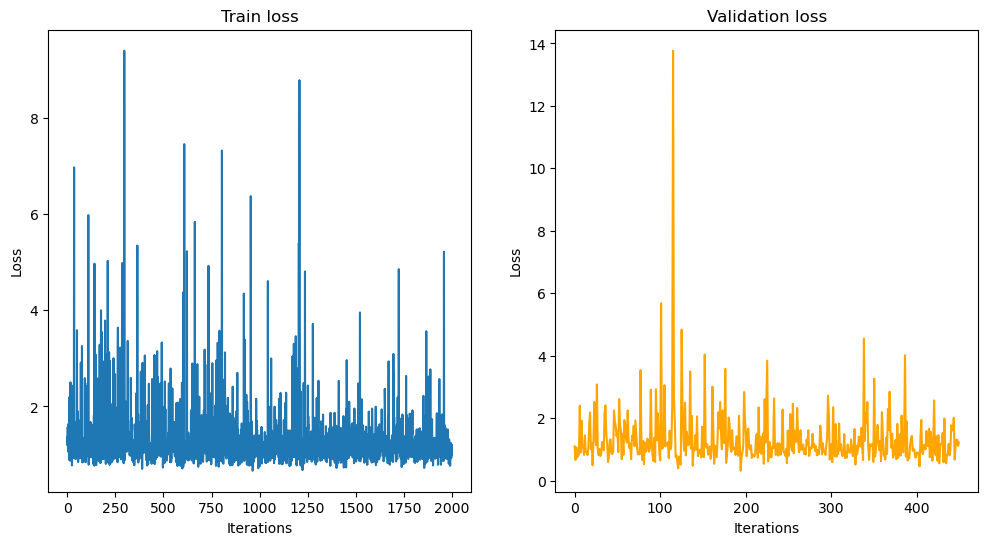

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
BNN_model = BayesianNeuralNetwork(32, 128, device=device)
BNN_model.to(device)
optimizer = torch.optim.Adam(BNN_model.parameters(), lr=3e-5)

losses, log_priors, log_variational_posteriors, NLLs, val_losses = train_BNN(BNN_model, optimizer, trainloader, valloader, epochs=500, model_name='BNN', val_every_n_epochs=10, device=device)

plot_loss(losses, val_losses)

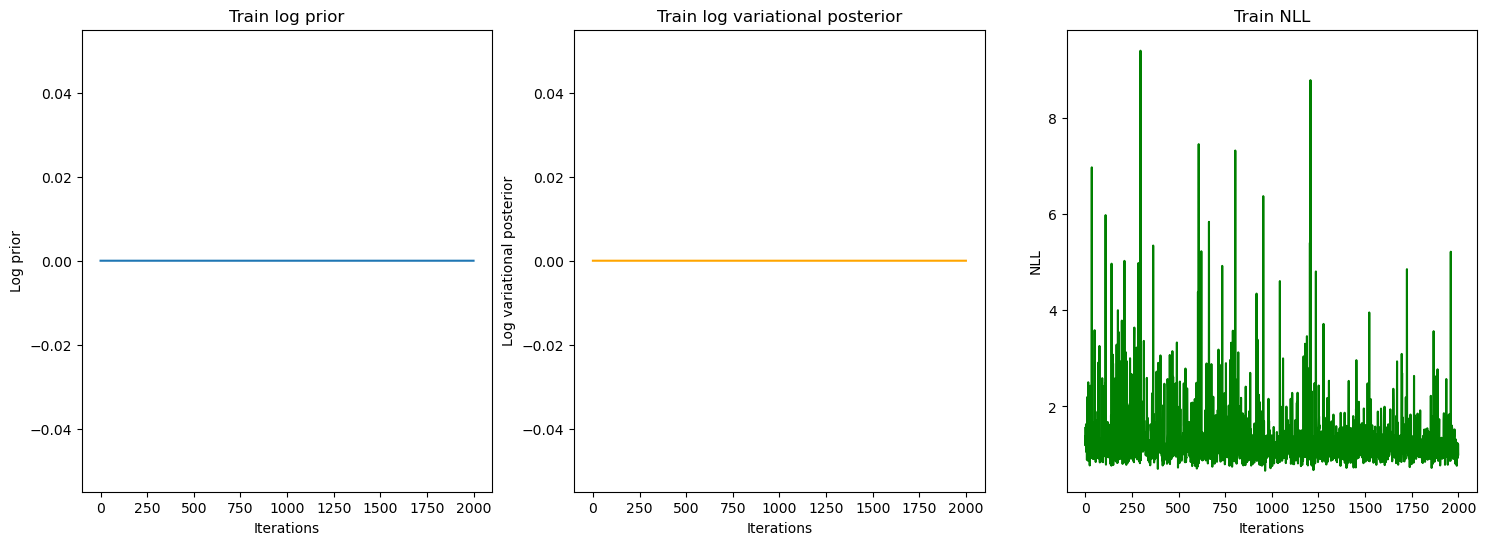

In [73]:
plot_log_probs(log_priors, log_variational_posteriors, NLLs)

In [49]:
model = torch.load("BNN.pt")

predictions = []
stds = []

for x_test, y_test in testloader:
    x_test, y_test = x_test.float(), y_test.float()
    with torch.no_grad():
        # output = model(x_test, inference=False)
        mu, rho = model(x_test, inference=False)
        # mu = output[:,0]
        # rho = output[:,1]
        sigma = model.get_sigma(rho)
        predictions.append(mu.cpu().detach().numpy())
        stds.append(sigma.cpu().detach().numpy())
        




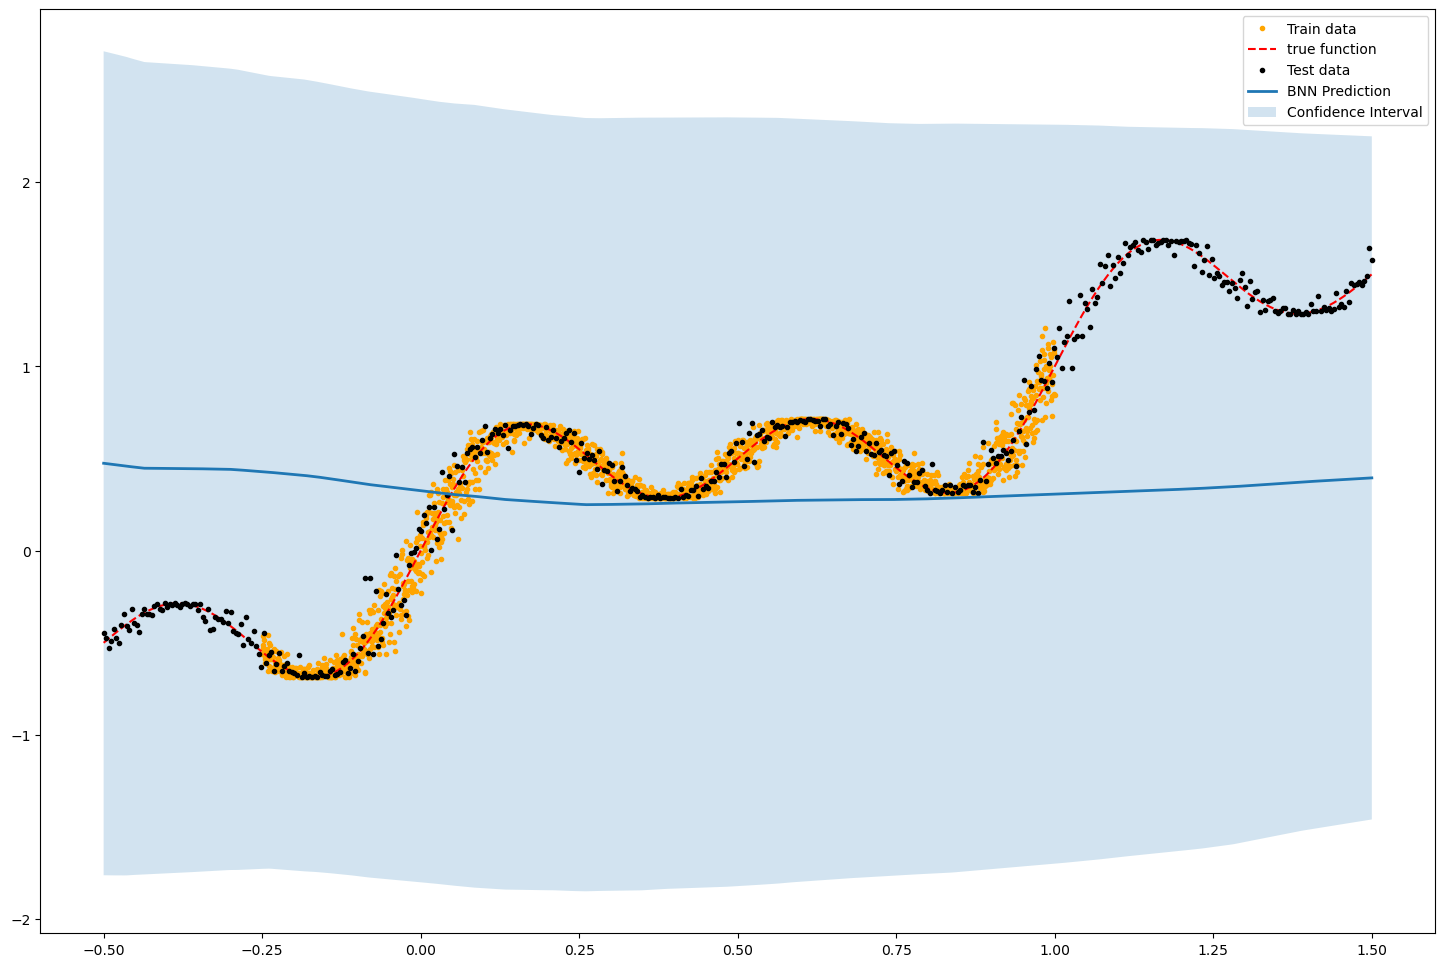

In [50]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(18,12))

### plot mimo ###
plt.plot(x, y, '.', label='Train data', color='orange')
plt.plot(x_test[:,0], line, '--', label='true function', color='red')
# plot test data
plt.plot(x_test[:,0], y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
plt.plot(x_test[:,0], predictions[0], '-', label=f'BNN Prediction', linewidth=2)
plt.fill_between(x_test[:,0], predictions[0][:,0] - 1.96*stds[0][:,0], predictions[0][:,0] + 1.96*stds[0][:,0], alpha=0.2, label=f'Confidence Interval')

plt.legend()

plt.show()
